In [1]:
# implementation of a character-based RNN to generate sonnets
import numpy as np
import random
import string
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Lambda
from keras.layers import SimpleRNN,LSTM
from keras.callbacks import LambdaCallback, EarlyStopping

In [2]:
def preprocess(filename="shakespeare.txt", seq_length=40, step=5):
    '''
    returns semi-redundant sequences their outputs 
    seq_length: number of characters in each sequence
    step: gets every [step] sequence  
    '''

    # puts all data into text string  
    file = open(filename, "r")
    text = ""
    for line in file:
        line = line.lstrip(' ').rstrip(' ')
        if line != '\n' and not line[0].isdigit():
            line.translate(str.maketrans('', '', string.punctuation))
            text += line.lower()

    # make char to index and index to char dictionary 
    characters = sorted(list(set(text)))
    char_indices_dict = dict((c, i) for i, c in enumerate(characters))
    indices_char_dict = dict((i, c) for i, c in enumerate(characters))
    #print(char_indices_dict)

    # makes every [step] char sequences of length seq_length and their outputs
    sequences = []
    next_chars = [] # next char that seq in sequences generates
    #print(repr(text[len(text) - 200:]))
    for i in range(0, len(text) - seq_length, step):
        #print(i, seq, text[i : i + seq_length])
        sequences.append(text[i : i + seq_length])
        next_chars.append(text[i + seq_length])

    # put sequences and outputs into np array
    x = np.zeros((len(sequences), seq_length, len(characters)))
    y = np.zeros((len(sequences), len(characters)), dtype=np.bool)
    for i, sequence in enumerate(sequences):
        for t, char in enumerate(sequence):
            x[i, t, char_indices_dict[char]] = 1
        y[i, char_indices_dict[next_chars[i]]] = 1

    return x, y, sequences, indices_char_dict, char_indices_dict, text

In [3]:
#seq_length: number of characters in each sequence
#step: gets every [step] sequence  

seq_length=40
step=5    
filename="shakespeare.txt"
# puts all data into text string  
file = open(filename, "r")
text = ""
for line in file:
    line = line.lstrip(' ').rstrip(' ')
    if line != '\n' and not line[0].isdigit():
        line.translate(str.maketrans('', '', string.punctuation))
        text += line.lower()

In [4]:
# make char to index and index to char dictionary 
characters = sorted(list(set(text)))
char_indices_dict = dict((c, i) for i, c in enumerate(characters))
indices_char_dict = dict((i, c) for i, c in enumerate(characters))
print(char_indices_dict)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


In [5]:
# makes every [step] char sequences of length seq_length and their outputs
sequences = []
next_chars = [] # next char that seq in sequences generates
print(repr(text[len(text) - 200:]))
for i in range(0, len(text) - seq_length, step):
    sequences.append(text[i : i + seq_length])
    next_chars.append(text[i + seq_length])

"fire took heat perpetual,\ngrowing a bath and healthful remedy,\nfor men discased, but i my mistress' thrall,\ncame there for cure and this by that i prove,\nlove's fire heats water, water cools not love."


In [6]:
# put sequences and outputs into np array
x = np.zeros((len(sequences), seq_length, len(characters)))
y = np.zeros((len(sequences), len(characters)), dtype=np.bool)
for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        x[i, t, char_indices_dict[char]] = 1
    y[i, char_indices_dict[next_chars[i]]] = 1

In [7]:
# using rnn to build model
def make_rnn(temperature=1.0):
    model = Sequential()
    model.add(SimpleRNN(100))
    # add temperature (controls variance)
    model.add(Lambda(lambda x: x / temperature))
    model.add(Dense(len(indices_char_dict), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

def make_lstm(temperature=1.0):
    model = Sequential()
    model.add(LSTM(100))
    # add temperature (controls variance)
    model.add(Lambda(lambda x: x / temperature))
    model.add(Dense(len(indices_char_dict), activation='softmax'))  
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [24]:
# model summary for RNN
x, y, sequences, indices_char_dict, char_indices_dict, text = preprocess()
print('model summary for rnn \n')
rnn_model=make_rnn(0.2)
rnn_model.build(x.shape)
rnn_model.summary()

model summary for rnn 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (18727, 100)              13900     
_________________________________________________________________
lambda_3 (Lambda)            (18727, 100)              0         
_________________________________________________________________
dense_3 (Dense)              (18727, 38)               3838      
Total params: 17,738
Trainable params: 17,738
Non-trainable params: 0
_________________________________________________________________


In [23]:
# model summary for lstm
print('model summary for lstm \n')
lstm_model=make_lstm(0.2)
lstm_model.build(x.shape)
lstm_model.summary()

model summary for lstm 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (18727, 200)              191200    
_________________________________________________________________
lambda_2 (Lambda)            (18727, 200)              0         
_________________________________________________________________
dense_2 (Dense)              (18727, 38)               7638      
Total params: 198,838
Trainable params: 198,838
Non-trainable params: 0
_________________________________________________________________


In [11]:
# training for RNN

earlyStopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')
rnn_history=rnn_model.fit(x, y, epochs=50, verbose=1, callbacks=[earlyStopping])
rnn_model.save('rnn.h5')

Epoch 1/50
586/586 [==============================] - 22s 29ms/step - loss: 3.0426 - accuracy: 0.2082
Epoch 2/50
586/586 [==============================] - 17s 30ms/step - loss: 2.3086 - accuracy: 0.3315
Epoch 3/50
586/586 [==============================] - 18s 30ms/step - loss: 2.1998 - accuracy: 0.3548
Epoch 4/50
586/586 [==============================] - 18s 30ms/step - loss: 2.1598 - accuracy: 0.3616
Epoch 5/50
586/586 [==============================] - 18s 30ms/step - loss: 2.1037 - accuracy: 0.3761
Epoch 6/50
586/586 [==============================] - 18s 30ms/step - loss: 2.0998 - accuracy: 0.3756
Epoch 7/50
586/586 [==============================] - 18s 30ms/step - loss: 2.0587 - accuracy: 0.3765
Epoch 8/50
586/586 [==============================] - 18s 30ms/step - loss: 2.0823 - accuracy: 0.3749
Epoch 9/50
586/586 [==============================] - 17s 30ms/step - loss: 2.0641 - accuracy: 0.3736
Epoch 10/50
586/586 [==============================] - 17s 29ms/step - loss: 2.040

In [10]:
#  training for LSTM
earlyStopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')
lstm_history=lstm_model.fit(x, y, epochs=50, verbose=1, callbacks=[earlyStopping])
lstm_model.save('lstm.h5')

Epoch 1/50
586/586 [==============================] - 27s 6ms/step - loss: 2.8025 - accuracy: 0.2195
Epoch 2/50
586/586 [==============================] - 4s 7ms/step - loss: 2.2302 - accuracy: 0.3461
Epoch 3/50
586/586 [==============================] - 4s 7ms/step - loss: 2.0961 - accuracy: 0.3788
Epoch 4/50
586/586 [==============================] - 4s 7ms/step - loss: 1.9680 - accuracy: 0.4157
Epoch 5/50
586/586 [==============================] - 4s 7ms/step - loss: 1.9022 - accuracy: 0.4259
Epoch 6/50
586/586 [==============================] - 4s 7ms/step - loss: 1.8031 - accuracy: 0.4549
Epoch 7/50
586/586 [==============================] - 4s 7ms/step - loss: 1.7342 - accuracy: 0.4665
Epoch 8/50
586/586 [==============================] - 4s 6ms/step - loss: 1.6398 - accuracy: 0.4949
Epoch 9/50
586/586 [==============================] - 4s 7ms/step - loss: 1.5843 - accuracy: 0.5131
Epoch 10/50
586/586 [==============================] - 4s 7ms/step - loss: 1.4957 - accuracy: 0.534

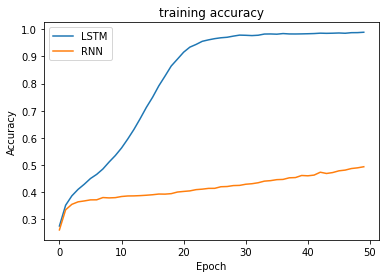

In [13]:
import matplotlib.pyplot as plt
# plot accuracy
plt.plot(lstm_history.history['accuracy'])
plt.plot(rnn_history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'RNN'], loc='upper left')
plt.show()

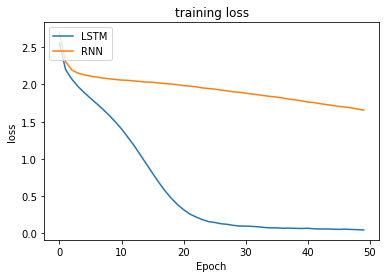

In [14]:
# plot loss
plt.plot(lstm_history.history['loss'])
plt.plot(rnn_history.history['loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'RNN'], loc='upper left')
plt.show()

In [15]:
def generate_sonnet(model_choice='rnn'):

    if model_choice=='rnn':
        model = load_model('rnn.h5')
    elif model_choice=='lstm':
        model = load_model('lstm.h5')
    sonnet = []
    
    seq = "shall i compare thee to a summer's day?\n"
    sonnet.append(seq)
    for _ in range(13):
        line = ""
        for i in range(40):
            x = np.zeros((1, len(seq), len(indices_char_dict)))
            for t, index in enumerate(seq):
                x[0, t, char_indices_dict[index]] = 1.

            prediction = model.predict(x, verbose=0)[0]
            index = np.argmax(prediction)
            char = indices_char_dict[index]
            line += char
            seq = seq[1:] + char

        sonnet.append(line)
    return sonnet

In [19]:
sonnet=generate_sonnet('rnn')
print('sonnet by rnn: \n')
for line in sonnet:
    print(line)

sonnet by rnn: 

shall i compare thee to a summer's day?

who har for my mathy sweet of the willon
g,
with in thy mine rare mand the for th
ou doth nought, and of and,
and the rear
the i not searn is with this can
wher i 
am the from should that thou destare,
an
d that thou a to growerthou doth nour wi
st,
the will this thy swall by the fart 
which the but tom seare coude,
and he fo
r thy leart the with nought love,
the wi
ll this thy swall by the fart which the 
but tom seare coude,
and he for thy lear
t the with nought love,
the will this th
y swall by the fart which the but tom se


In [22]:
sonnet=generate_sonnet('lstm')

print('sonnet by lstm: \n')
for line in sonnet:
    print(line)

sonnet by lstm: 

shall i compare thee to a summer's day?

why shand o the more do so an in the lin
g.
and of the remooh dooms fragest thind
 appire,
and the faire of the fould that
 heart
wost o thou stellst in hoscas yea
re,
and to the would that thou art as a 
curuse,
of ,hy reasong bange there thes 
farted to my love,
that thy sell han why
 bothe sam a rece day
, time mud love in
s fairs of thine should hast ince,
thou 
stange to glves to a mm boldenss beed,
t
he bring beaut of heart, in in a woulds 
if is halllly:
a thee, will nair woinney
,
my lovely my love me as wite on my mis
